# Решение классификации с помощью CatBoost

## Установка библиотек

In [1]:
#!pip install --user --upgrade catboost
#!pip install --user --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!pip install --upgrade numpy
#!jupyter nbextension enable --py widgetsnbextension

## Чтение данных

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
#filepath
file_path= "telco-customer-churn.csv"

In [18]:
df=pd.read_csv(file_path)
df

,Unnamed: 0,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,...,15,19,No,No,0.82,5971,663,0,2015,1
1,1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,...,15,19,No,No,0.82,3981,995,0,2015,2
2,2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,...,212,34,No,Yes,0.27,7379,737,0,2015,1
3,3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,...,212,34,No,Yes,0.27,1729,432,0,2015,2
4,4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,...,216,144,No,No,0.48,3122,624,0,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20463,20463,33,67056,0.07,0.00,4251050233,9523,Yes,Bachelor or equivalent,Male,...,249,172,No,No,0.38,7651,850,1,2015,2
20464,20464,49,65084,0.01,0.01,4251050074,9524,Yes,Master or equivalent,Female,...,252,32,No,No,0.59,3241,648,0,2015,1
20465,20465,49,65084,0.01,0.01,4251050074,9524,Yes,Master or equivalent,Female,...,252,32,No,No,0.59,5034,719,0,2015,2
20466,20466,51,120042,0.05,0.01,4251075688,9525,Yes,Master or equivalent,Male,...,351,67,No,No,0.12,7200,720,0,2015,1


In [19]:
writer = pd.ExcelWriter('df.xlsx')
df.to_excel(writer,'Sheet1')

## Подготовка данных

Извлечение значений меток

In [16]:
y = df.churn
X = df.drop(['churn', 'year', 'month', 'noadditionallines'], axis=1)

Декларация категориальных признаков

In [5]:
cat_features = list(X.select_dtypes(include=['object']).columns.values.tolist())
cat_features

['customersuspended',
 'education',
 'gender',
 'homeowner',
 'maritalstatus',
 'occupation',
 'state',
 'usesinternetservice',
 'usesvoiceservice']

Просмотр баланса меток в наборе данных

In [6]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 18605, One count = 1863


## Разделение данных на train и test

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Создание класса Pool

In [8]:
from catboost import Pool

# Training and testing Pool
ptrain = Pool(data=X_train, label=y_train, cat_features=cat_features)
ptest = Pool(data=X_test, label=y_test, cat_features=cat_features)

print('Training Pool shape: ', ptrain.shape)
print('Testing Pool shape : ', ptest.shape)

Training Pool shape:  (16374, 25)
Testing Pool shape :  (4094, 25)


Вспомогательные функции

In [9]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, log_loss
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
sns.set()

def metrics(clf_name, ordered_dict):
    # Print best iteration round number
    best_iteration = clf_name.best_iteration_
    # Calculate AUCPR
    probs = clf_name.predict_proba(X_test)[:, 1]
    auc_mtr = roc_auc_score(y_test, probs)
    aucpr_mtr = average_precision_score(y_test, probs)
    logloss_mtr = log_loss(y_test, probs)
    preds = clf_name.predict(X_test)
    precision_mtr = precision_score(y_test, preds)
    recall_mtr = recall_score(y_test, preds)
    f1_mtr = f1_score(y_test, preds)
    # Print metrics
    print('Best iteration: {} rounds.'.format(best_iteration))
    print('AUC:       {0:.3f}'.format(auc_mtr))
    print('AUCPR:     {0:.3f}'.format(aucpr_mtr))
    print('Logloss:   {0:.3f}'.format(logloss_mtr))
    print('Precision: {0:.3f}'.format(precision_mtr))
    print('Recall:    {0:.3f}'.format(recall_mtr))
    print('F1-score:  {0:.3f}'.format(f1_mtr))
    # Append metrics to an ordered dictionary (for plotting)
    ordered_dict['Best_iteration'] = best_iteration
    ordered_dict['AUC'] = round(auc_mtr, 3)
    ordered_dict['AUCPR'] = round(aucpr_mtr, 3)
    ordered_dict['Logloss'] = round(logloss_mtr, 3)
    ordered_dict['Precision'] = round(precision_mtr, 3)
    ordered_dict['Recall'] = round(recall_mtr, 3)
    ordered_dict['F1_score'] = round(f1_mtr, 3)
    
def plot_consec_metric_delta(label1, dict1, label2, dict2):
    df = pd.DataFrame(
        data=[[val for (metric, val) in dict1.items()],
              [val for (metric, val) in dict2.items()]],
        columns=[metric for (metric, val) in dict1.items()]
    )

    bst_iters = list(df['Best_iteration'])

    df.drop(['Best_iteration'], axis=1, inplace=True)

    N = 2
    ind = np.arange(N)    
    plt.figure(figsize=(6, 6))
    for metric in list(df.columns):
        plt.plot(ind, df[metric].values, linewidth=1.5, marker='o', label=metric);
    plt.xticks(
        ticks=np.arange(N),
        labels=[
            '{}\n{} rounds'.format(label1, bst_iters[0]),
            '{}\n{} rounds'.format(label2, bst_iters[1])])
    plt.title('Метрики моделей при последовательных итерациях', fontsize=13)
    plt.ylabel('Значение', fontsize=12)
    plt.xlabel('Итерация', fontsize=12)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show()

## Постоение и сравнение моделей

In [10]:
from catboost import CatBoostClassifier

# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     # метрика, используемая при обучении
    'custom_metric': ['Precision', 'Recall', 'AUC'],   # отображаются только в информационных целях
    'eval_metric': 'F1', # метрика, используемая для обнаружения переобучения и выбора лучшей модели
    'cat_features': cat_features,
    'train_dir': 'clf_baseline'
}

# Instantiate classifier
clf_baseline = CatBoostClassifier(**params)

# Fit classifier
clf_baseline.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=150,
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_baseline_dict = OrderedDict()
metrics(clf_baseline, clf_baseline_dict)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 981 rounds.
AUC:       0.960
AUCPR:     0.884
Logloss:   0.127
Precision: 0.980
Recall:    0.528
F1-score:  0.686


Подбор значения для параметра scale_pos_weight. 

In [11]:
train_labels = ptrain.get_label()
pos_class = sum(i for i in train_labels)
neg_class = len(train_labels) - pos_class
ratio = neg_class / pos_class
print('Value for scale_pos_weight: {:.2f}'.format(ratio))

Value for scale_pos_weight: 9.99


In [12]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'AUC'], 
    'eval_metric': 'F1',
    'scale_pos_weight': 9.99,
    'cat_features': cat_features,
    'train_dir': 'clf_equalize'
}

# Instantiate classifier
clf_equalize = CatBoostClassifier(**params)

# Fit classifier
clf_equalize.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=150,
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_equalize_dict = OrderedDict()
metrics(clf_equalize, clf_equalize_dict)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 976 rounds.
AUC:       0.960
AUCPR:     0.897
Logloss:   0.143
Precision: 0.840
Recall:    0.861
F1-score:  0.850


Перераспределение весов классов повлияло на метрики модели, особенно на показатель recall и precision. 

Сравнение базовой модели со сбалансированной моделью.

Baseline model:
Best iteration: 981 rounds.
AUC:       0.960
AUCPR:     0.884
Logloss:   0.127
Precision: 0.980
Recall:    0.528
F1-score:  0.686

Equalized model:
Best iteration: 976 rounds.
AUC:       0.960
AUCPR:     0.897
Logloss:   0.143
Precision: 0.840
Recall:    0.861
F1-score:  0.850


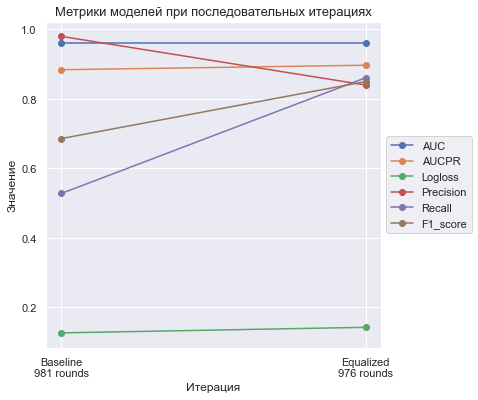

In [13]:
print('Baseline model:')
metrics(clf_baseline, clf_baseline_dict)

print('\nEqualized model:')
metrics(clf_equalize, clf_equalize_dict)

plot_consec_metric_delta('Baseline', clf_baseline_dict, 'Equalized', clf_equalize_dict)

## Контроль над переобучением

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 1517 rounds.
AUC:       0.961
AUCPR:     0.898
Logloss:   0.125
Precision: 0.904
Recall:    0.858
F1-score:  0.880


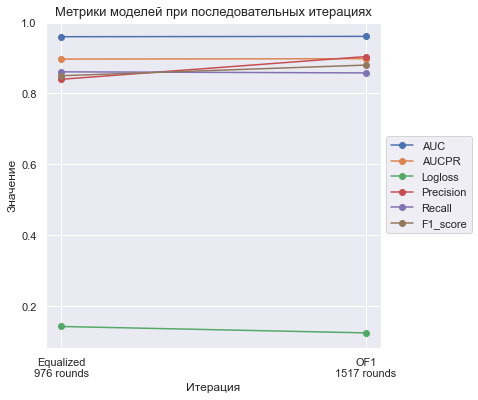

In [14]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'AUC'], 
    'eval_metric': 'F1',
    'scale_pos_weight': 9.99,
    'cat_features': cat_features,
    'iterations': 2000,        # finding best iteration
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 20,
    'train_dir': 'clf_of1'
}

# Instantiate classifier
clf_of1 = CatBoostClassifier(**params)

# Fit classifier
clf_of1.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=150,   
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_of1_dict = OrderedDict()
metrics(clf_of1, clf_of1_dict)
plot_consec_metric_delta('Equalized', clf_equalize_dict, 'OF1', clf_of1_dict)

Наилучшее количество итераций, оптимизирующих F1-score во время обучения, составляет 1517 деревьев.
Учитывая, что у нас включены параметры use_best_model и обнаружения переобучения, оптимальное количество деревьев будет меняться при разных параметрах.
Поэтому мы установим параметр iterations в высокое значение (3000 в нашем случае) и позволим алгоритму определить наилучшее количество итераций при подгонке каждого классификатора на последующих итерациях настройки.

скорость обучения для базовой модели

In [15]:
clf_equalize.learning_rate_

0.06321299821138382

скорость обучения для первой итерации с контролем переобучения

In [17]:
clf_of1.learning_rate_

0.04675799980759621

CatBoost определяет практически оптимальную скорость обучения для лучшей итерации классификатора.
Использую скорость обучения на лучшей итерации для подбора лучшиго сочетания параметров max_depth и reg_lambda.

*Согласно документации CatBoost, по умолчанию скорость обучения определяется автоматически на основе свойств набора данных и количества итераций.


## Параметры max_depth и reg_lambda

В большинстве случаев оптимальная глубина находится в диапазоне от 4 до 10. Рекомендуются значения в диапазоне от 6 до 10. 

    max_depth: Глубина дерева. (по умолчанию: 6)
    reg_lambda: Коэффициент при L2-члене регуляризации. (по умолчанию: 3.0)
    
#### Кросс-валидация

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time 

# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
#     'custom_metric': ['Precision', 'Recall', 'AUC'],   # N/A to gridsearch
    'eval_metric': 'F1',
    'scale_pos_weight': 9.99,
    'cat_features': cat_features,
    'iterations': 50,        
#     'use_best_model': True,  # N/A to gridsearch
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0
}

# Parameters to tune
param_grid = {
    'max_depth': [8, 10, 12],
    'reg_lambda': [2, 3, 4]
}

clf_of2_grid = GridSearchCV(
    estimator=CatBoostClassifier(**params),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=0
)

# Fit the grid search object
%time clf_of2_grid.fit(X_train, y_train)

print('Best f1-score: {0:.3f}'.format(clf_of2_grid.best_score_))
print('Best params:')
for key, val in clf_of2_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Wall time: 5min 57s
Best f1-score: 0.655
Best params:
	max_depth: 12
	reg_lambda: 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 413 rounds.
AUC:       0.972
AUCPR:     0.916
Logloss:   0.085
Precision: 0.997
Recall:    0.847
F1-score:  0.916


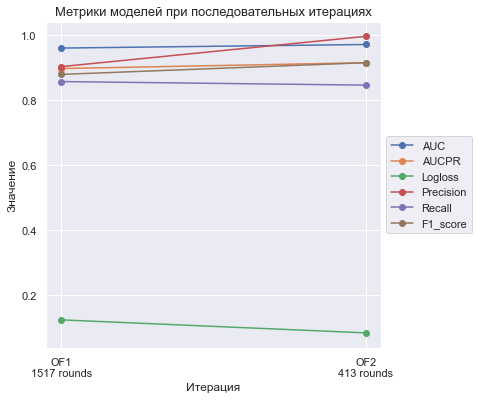

In [37]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'AUC'], 
    'eval_metric': 'F1',
    'scale_pos_weight': 9.99,
    'cat_features': cat_features,
    'iterations': 3000,        # finding best iteration
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0,
    'max_depth': 10,
    'reg_lambda': 2,
    'train_dir': 'clf_of2'
}

# Instantiate classifier
clf_of2 = CatBoostClassifier(**params)

# Fit classifier
clf_of2.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,   
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_of2_dict = OrderedDict()
metrics(clf_of2, clf_of2_dict)
plot_consec_metric_delta('OF1', clf_of1_dict, 'OF2', clf_of2_dict)

Precision увеличилась, но продолжила падать Recall

In [26]:
clf_of2.learning_rate_

0.029999999329447746

## Сравнение моделей на итерациях

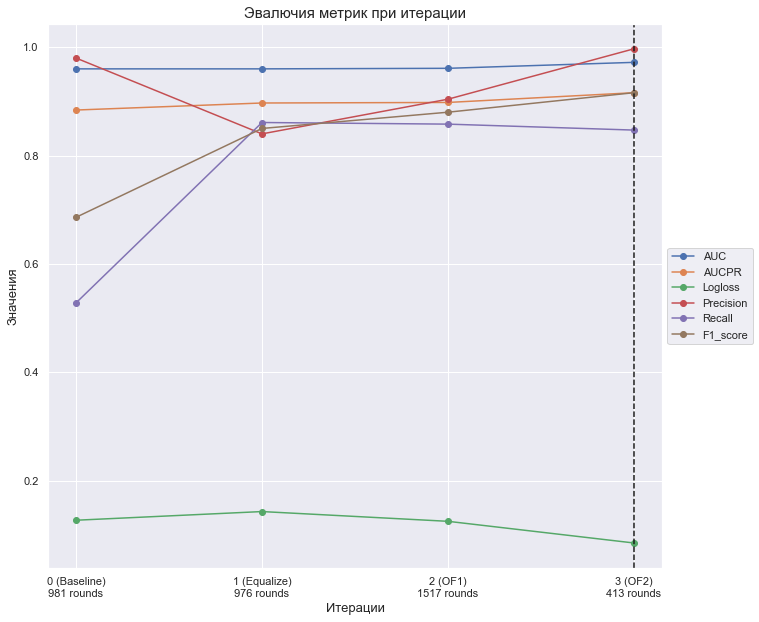

In [21]:
df_final = pd.DataFrame(
    data=[[val for (metric, val) in clf_baseline_dict.items()],
          [val for (metric, val) in clf_equalize_dict.items()],
          [val for (metric, val) in clf_of1_dict.items()],
          [val for (metric, val) in clf_of2_dict.items()],
         ],
    columns=[metric for (metric, val) in clf_baseline_dict.items()]
    ).rename(index={
    0: 'Baseline',
    1: 'Equalize',
    2: 'OF1',
    3: 'OF2'
})

# Store best iterations
bst_iters_final = list(df_final['Best_iteration'])

# Drop the 'Best_iteration' column inplace
df_final.drop(['Best_iteration'], axis=1, inplace=True)

# Define # of iterations you want to plot
N = len(df_final.index)
ind = np.arange(N) 

# Plot metrics
plt.figure(figsize=(11, 10))
for metric in list(df_final.columns):
    plt.plot(ind, df_final[metric].values, linewidth=1.5, marker='o', label=metric);

# Best tuning iteration
plt.axvline(x=3, color='k', linestyle='--')

# Labels
plt.xticks(
    ticks=np.arange(N),
    labels=[
        '0 (Baseline)\n{} rounds'.format(bst_iters_final[0]),
        '1 (Equalize)\n{} rounds'.format(bst_iters_final[1]),
        '2 (OF1)\n{} rounds'.format(bst_iters_final[2]),
        '3 (OF2)\n{} rounds'.format(bst_iters_final[3])
    ])
plt.title('Эвалючия метрик при итерации', fontsize=15)
plt.ylabel('Значения', fontsize=13)
plt.xlabel('Итерации', fontsize=13)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

### Визуализация обучения моделей оригинальным способом

In [24]:
from catboost import MetricVisualizer
MetricVisualizer(['clf_baseline', 'clf_equalize', 'clf_of1', 'clf_of2']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [25]:
df_final

,AUC,AUCPR,Logloss,Precision,Recall,F1_score
Baseline,0.960,0.884,0.127,0.980,0.528,0.686
Equalize,0.960,0.897,0.143,0.840,0.861,0.850
OF1,0.961,0.898,0.125,0.904,0.858,0.880
OF2,0.972,0.916,0.085,0.997,0.847,0.916


Модель CatBoost показывает наилучшие результаты на четвертой настройке параметров, показывая незначительно худший результат по метрике Recall.


## Итоговая модель

In [79]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'AUC'], 
    'eval_metric': 'F1',
    'scale_pos_weight': 9.99,
    'cat_features': cat_features,
    'iterations': 2000,        # finding best iteration
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0,
    'max_depth': 10,
    'reg_lambda': 2,
    'learning_rate': 0.029
}

# Instantiate classifier
clf_of3 = CatBoostClassifier(**params)

# Fit classifier
clf_of3.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,   
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_of3_dict = OrderedDict()
metrics(clf_of3, clf_of3_dict)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 624 rounds.
AUC:       0.968
AUCPR:     0.909
Logloss:   0.091
Precision: 0.994
Recall:    0.850
F1-score:  0.916


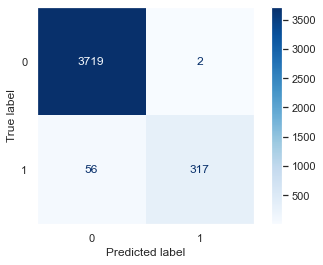

In [115]:
# матрица ошибок
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf_of3,X_test,y_test,cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

## Выбор границы принятия решения (исходя из бизнес аналитики)

Поиск границ для наилучших показателей FPR, FNR

In [85]:
from catboost.utils import get_roc_curve
import sklearn

eval_pool = Pool(X_test, y_test, cat_features=cat_features)
curve = get_roc_curve(clf_of3, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

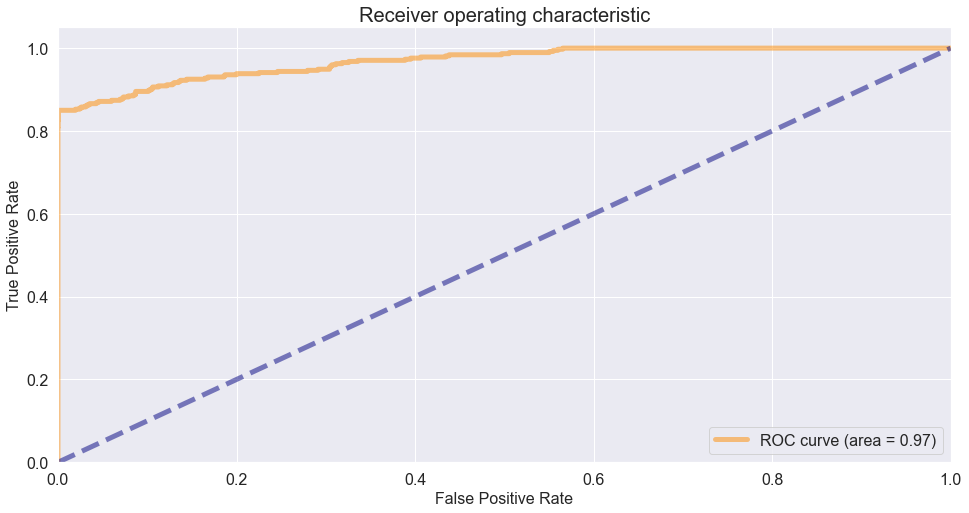

In [112]:
plt.figure(figsize=(16, 8))
lw = 5

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [87]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

Строю график соотношения FPR и FNR (ошибки первого и второго рода) для принятия решения о сдвиге функции активации.
Решение нужно принимать с учетом того, что уменьшение ошибки первого или второго рода неизбежно приведет к увеличению противоположенной. 

(дефолтное значение == 0.5)

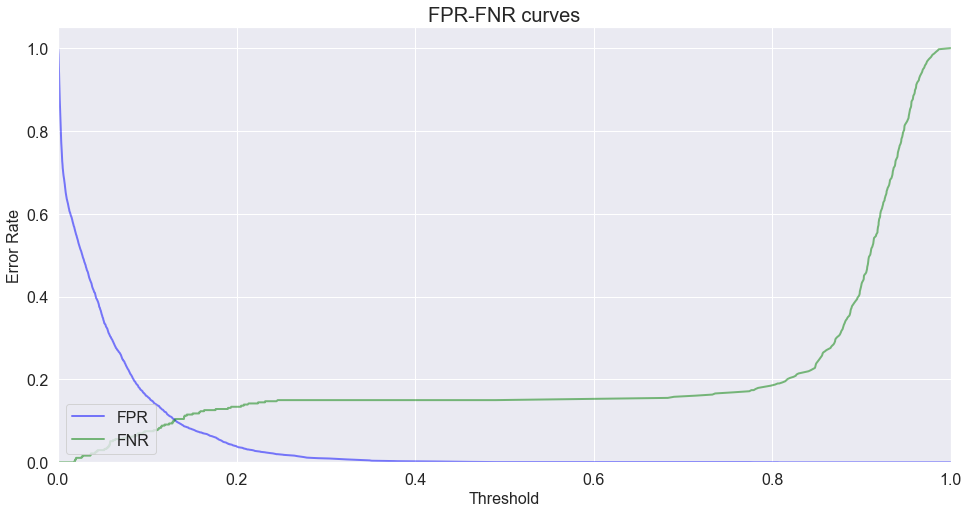

In [88]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [90]:
from catboost.utils import select_threshold

print(select_threshold(model=clf_of3, data=eval_pool, FNR=0.18))
print(select_threshold(model=clf_of3, data=eval_pool, FPR=0.18))

0.7842333090006073
0.0913413503190992


Получение вероятностных значений

In [119]:
contest_predictions = best_model.predict_proba(ptest)
print('Predictoins:')
print(contest_predictions)

Predictoins:
[[0.9 0.1]
 [0.9 0.1]
 [1.  0. ]
 ...
 [0.8 0.2]
 [0.3 0.7]
 [1.  0. ]]


## Shap values

In [100]:
shap_values = clf_of3.get_feature_importance(ptest, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

(4094, 25)


Shap предоставляет возможность работы с отдельно взятым экземпляром
(красная область - повышающие атрибуты оттока, синяя - понижающие)

In [102]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

In [103]:
shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X.iloc[91,:])

## Важность фичей

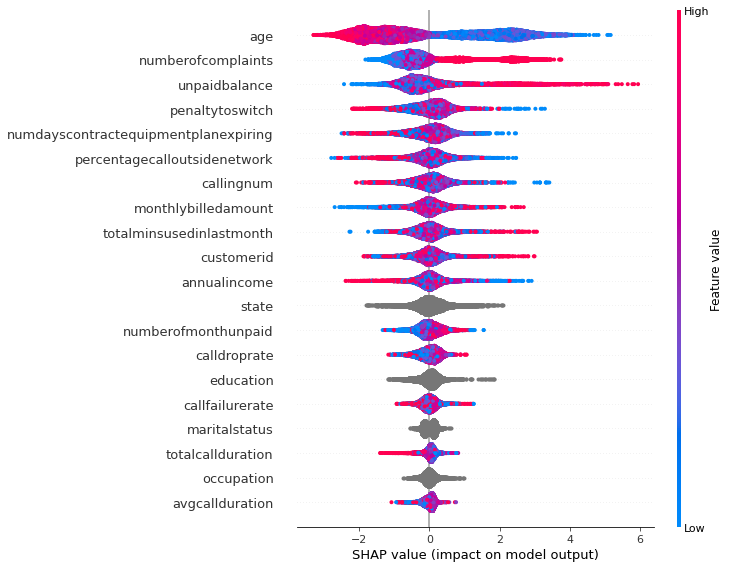

In [103]:
shap.summary_plot(shap_values, X)

Как его читать:

    * значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
    * чем толще линия на графике, тем больше таких точек наблюдения
    * чем краснее точки на графике, тем выше значения фичи в ней


Из графика можно сделать интересные выводы и проверить их адекватность:

    * чем старше клиент, тем менее вероятен его отток
    * с возрастанием количества жалоб увеличивается вероятность оттока
    * рост неоплаченного баланса стимулирует отток
    ...

Кроме того, есть возможность работы со срезами (цветовая схема идентична)

In [104]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

 ## Сохранение модели в формате .json

In [106]:
clf_of3.save_model('catboost_model.json', format='json')

## BigData

In [7]:
df.to_parquet('telco-customer-churn.parquet')  